# **Laporan Analisis Big Data - Fesmaro 2025**

Dokumentasi ini merangkum proses pemrosesan data dan analisis eksploratif (EDA) yang dilakukan pada dataset Ulasan Amazon (`kritanjalijain/amazon-reviews` dari Kaggle), sebagaimana terdokumentasi dalam notebook `fesmaro-2025-analisis-big-data.ipynb`. Tujuannya adalah untuk menghasilkan DataFrame akhir (`final_df`) yang siap digunakan untuk pemodelan klasifikasi sentimen.

---

## 1. Pemrosesan Data Awal

Tahap ini mencakup persiapan awal dataset sebelum analisis lebih lanjut.

### 1.1. Import Libraries

Pustaka-pustaka standar Python dan pustaka khusus untuk analisis data, visualisasi, dan NLP diimpor, termasuk:
- `pandas` & `numpy` untuk manipulasi data.
- `matplotlib` & `seaborn` untuk visualisasi.
- `nltk`, `re`, `string`, `contractions` untuk pemrosesan teks (tokenisasi, stopwords, lemmatisasi, pembersihan).
- `sklearn.feature_extraction.text` untuk ekstraksi fitur TF-IDF.
- `wordcloud` untuk visualisasi frekuensi kata.

Resource NLTK yang diperlukan (`punkt`, `stopwords`, `wordnet`) juga diunduh.

In [1]:
# Standard libraries
import os
import re
import string
from multiprocessing import Pool
from collections import Counter

# Data processing and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import contractions

# NLTK for natural language processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer

# Scikit-learn for feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harry\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\harry\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
#!pip freeze | grep -E "numpy|pandas|matplotlib|seaborn|nltk" > requirements.txt

In [21]:
#!cat requirements.txt

### 1.2. Pemuatan Data

- Dataset Ulasan Amazon dimuat dari file `train.csv` dan `test.csv`.
- Informasi awal menunjukkan `df_train` memiliki 3.6 juta baris dan 3 kolom tanpa header.

In [22]:
#!pip install kagglehub

In [23]:
# import kagglehub
# amazon_reviews_path = kagglehub.dataset_download('kritanjalijain/amazon-reviews')

# # Load the pre-split train and test datasets
# df_train = pd.read_csv(f"{amazon_reviews_path}/train.csv")
# df_test = pd.read_csv(f"{amazon_reviews_path}/test.csv")

# # Verify the data
# print("Training data shape:", df_train.shape)
# print("Test data shape:", df_test.shape)

### Troubleshooting
- If you encounter a ModuleNotFoundError for kagglehub, run the installation command above.
- If you get authentication errors with kagglehub, ensure you have a Kaggle account and have set up your API credentials.
- For persistent loading issues, download the dataset manually from Kaggle and adjust the file paths accordingly.

In [2]:
df_train = pd.read_csv('./kaggle/input/amazon-reviews/train.csv')
df_test = pd.read_csv('./kaggle/input/amazon-reviews/test.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3599999 entries, 0 to 3599998
Data columns (total 3 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                      Dtype 
---  ------                                                                                                                                                                                                                                                                                                                                                                                                      ----- 
 0   2                                                                  

### 1.3. Penamaan Kolom

- Nama kolom yang deskriptif (`label`, `title`, `text`) diberikan pada `df_train` dan `df_test`.

In [4]:
df_train.columns = ['label', 'title', 'text']
df_test.columns = ['label', 'title', 'text']

### 1.4. Perubahan Label Sentimen

- Label sentimen asli (1 untuk negatif, 2 untuk positif) diubah menjadi representasi biner (0 untuk negatif, 1 untuk positif) menggunakan pemetaan `{1:0, 2:1}`.

In [5]:
df_train['label'] = df_train['label'].map({1:0, 2:1})
df_test['label'] = df_test['label'].map({1:0, 2:1})

### 1.5. Penggabungan Kolom Teks

- Kolom `title` dan `text` digabungkan menjadi satu kolom `text` tunggal untuk menyatukan konten ulasan. Kolom `title` kemudian dihapus.

In [6]:
def concat_columns(df, col1, col2, new_col):
    df[new_col] = df[col1].apply(str) + ' ' + df[col2].apply(str)
    df.drop(col2, axis = 1, inplace = True)
    return df

df_train = concat_columns(df_train, 'text', 'title', 'text')
df_test = concat_columns(df_test, 'text', 'title', 'text')

---

## 2. Exploratory Data Analysis (EDA)

Analisis dilakukan pada `df_train` (sebelum sampling) untuk memahami karakteristik data.

### 2.1. Informasi Dasar & Nilai Hilang

- Setelah persiapan awal, `df_train` memiliki 3.6 juta baris dan 2 kolom (`label`, `text`).
- Pemeriksaan nilai hilang menunjukkan **tidak ada nilai hilang** di kedua kolom.

In [7]:
print(f"Dataset shape: {df_train.shape}")
print(f"Columns: {df_train.columns.tolist()}")
print("\nSample data:")
print(df_train.head())

Dataset shape: (3599999, 2)
Columns: ['label', 'text']

Sample data:
   label                                               text
0      1  I'm reading a lot of reviews saying that this ...
1      1  This soundtrack is my favorite music of all ti...
2      1  I truly like this soundtrack and I enjoy video...
3      1  If you've played the game, you know how divine...
4      1  I am quite sure any of you actually taking the...


In [8]:
print("\nMissing values:")
print(df_train.isnull().sum())


Missing values:
label    0
text     0
dtype: int64


### 2.2. Distribusi Kelas

- **Jumlah:** Dataset awal sangat seimbang, dengan sekitar 1.8 juta ulasan untuk setiap kelas (0: negatif, 1: positif). Dataset `test.csv` juga menunjukkan keseimbangan serupa (sekitar 200 ribu per kelas).
- **Visualisasi:** Bar plot mengonfirmasi distribusi kelas yang hampir 50/50 pada `df_train`.

In [9]:
print(df_train['label'].value_counts())
print(df_test['label'].value_counts())

label
0    1800000
1    1799999
Name: count, dtype: int64
label
0    200000
1    199999
Name: count, dtype: int64


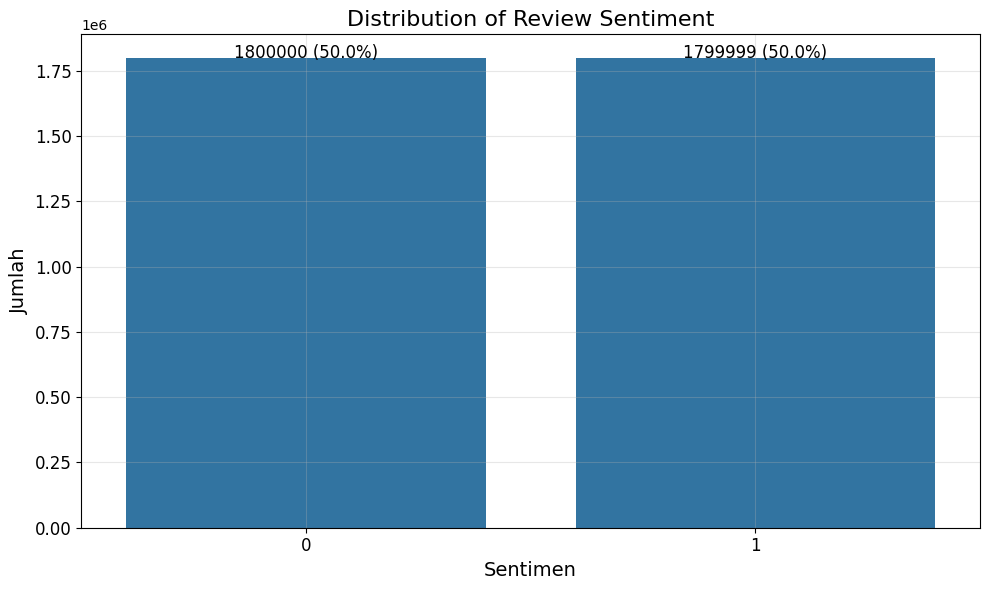

In [10]:
# Distribusi label sentimen
plt.figure(figsize=(10, 6))
sentiment_counts = df_train['label'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Review Sentiment', fontsize=16)
plt.xlabel('Sentimen', fontsize=14)
plt.ylabel('Jumlah', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3)

# Menambahkan nilai di atas bar
for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v + 50, f"{v} ({v/sum(sentiment_counts.values):.1%})", 
             ha='center', fontsize=12)

plt.tight_layout()
plt.show()

**Diagram Batang: Distribusi Sentimen Ulasan**

- Visualisasi: Diagram batang ini menampilkan jumlah ulasan untuk masing-masing kelas sentimen (0 untuk negatif, 1 untuk positif) dalam dataset latih awal (df_train sebelum sampling). Terlihat dua batang dengan tinggi yang hampir sama persis.

- Deskripsi Data: Sumbu X merepresentasikan label sentimen (0 dan 1), dan sumbu Y menunjukkan jumlah ulasan. Terdapat teks di atas setiap batang yang menunjukkan jumlah absolut dan persentase relatifnya.

- Insight:

    - Keseimbangan Kelas Sempurna: Insight paling signifikan dari plot ini adalah dataset latih awal memiliki keseimbangan kelas yang luar biasa baik. Terdapat sekitar 1.8 juta ulasan negatif (label 0) dan 1.8 juta ulasan positif (label 1), masing-masing mewakili 50.0% dari total data.

    - Implikasi untuk Pemodelan: Keseimbangan ini sangat ideal untuk memulai pemodelan klasifikasi. Model tidak akan cenderung bias terhadap kelas mayoritas karena tidak ada kelas mayoritas. Ini menyederhanakan proses awal karena kita tidak perlu langsung menerapkan teknik penanganan ketidakseimbangan data seperti oversampling atau undersampling (meskipun sampling dilakukan kemudian karena alasan komputasi).

    - Representativitas: Ini menunjukkan bahwa dataset asli (dari Kaggle) dirancang untuk menjadi seimbang, yang bagus untuk tugas evaluasi model yang adil.



### 2.3. Analisis Panjang Teks & Jumlah Kata

- **Panjang Karakter (`text_length`):**
  - Statistik: Rata-rata panjang ulasan adalah ~431 karakter, dengan standar deviasi ~238. Panjang minimum 71, maksimum 1014.
  - Distribusi per Kelas: Ulasan negatif (label 0) cenderung sedikit lebih panjang (rata-rata 446) dibandingkan ulasan positif (label 1, rata-rata 415).
  - Visualisasi (Histogram): Distribusi panjang teks cenderung miring ke kanan (right-skewed), menunjukkan mayoritas ulasan memiliki panjang di bawah rata-rata, namun ada beberapa ulasan yang cukup panjang.

In [11]:
# Count Text Length and Word Count
df_train['text_length'] = df_train['text'].apply(len)

print("\nText length statistics:")
print(df_train['text_length'].describe())


Text length statistics:
count    3.599999e+06
mean     4.306463e+02
std      2.375527e+02
min      7.100000e+01
25%      2.300000e+02
50%      3.820000e+02
75%      5.940000e+02
max      1.014000e+03
Name: text_length, dtype: float64


In [12]:
length_stats = df_train.groupby('label')[['text_length']].agg(['mean', 'median', 'min', 'max'])
print(length_stats)

      text_length                 
             mean median min   max
label                             
0      446.454255  404.0  88  1014
1      414.838378  359.0  71  1014


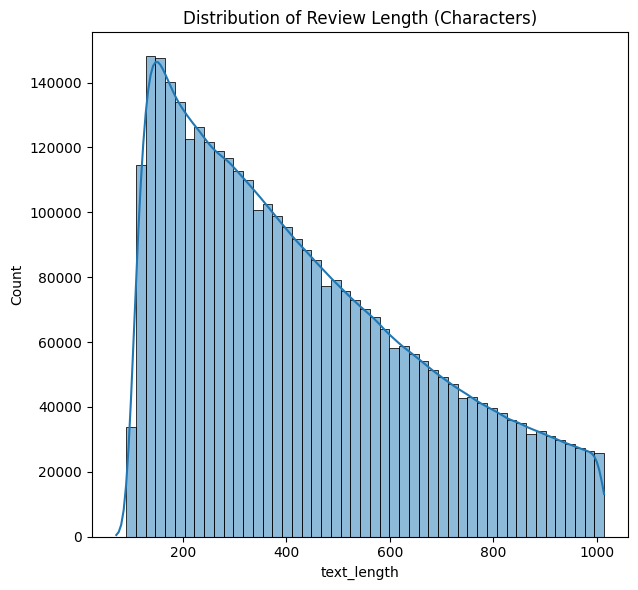

In [13]:
# Plot length distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_train['text_length'],kde=True, bins=50)
plt.title('Distribution of Review Length (Characters)')
plt.tight_layout()
plt.show()

- **Jumlah Kata (`word_count`):**
  - Statistik: Rata-rata jumlah kata per ulasan adalah ~78, dengan standar deviasi ~43. Minimum 2, maksimum 257.
  - Distribusi per Kelas: Ulasan negatif (rata-rata 81.5 kata) juga cenderung memiliki lebih banyak kata daripada ulasan positif (rata-rata 75.5 kata).
  - Visualisasi (Histogram): Distribusi jumlah kata juga miring ke kanan.

In [14]:
# Word Count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))

print("\nWord count statistics:")
print(df_train['word_count'].describe())


Word count statistics:
count    3.599999e+06
mean     7.848273e+01
std      4.283281e+01
min      2.000000e+00
25%      4.200000e+01
50%      7.000000e+01
75%      1.080000e+02
max      2.570000e+02
Name: word_count, dtype: float64


In [15]:
length_stats = df_train.groupby('label')[['word_count']].agg(['mean', 'median', 'min', 'max'])
print(length_stats)

      word_count                
            mean median min  max
label                           
0      81.502666   74.0   2  257
1      75.462798   66.0   2  222


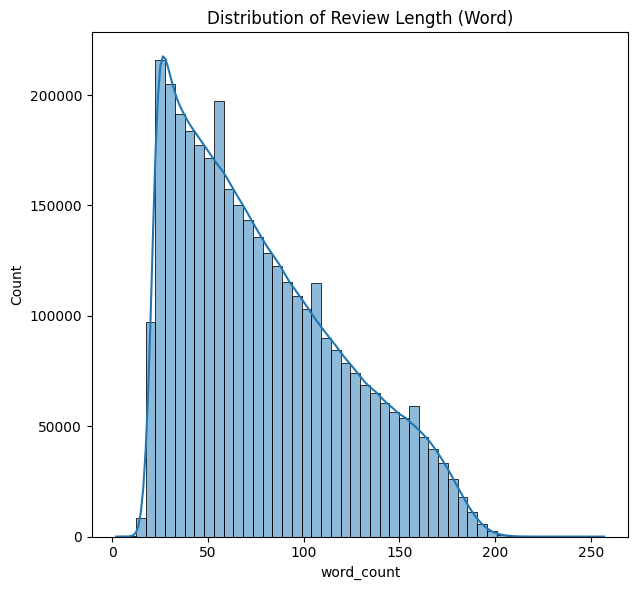

In [16]:
# Plot word count distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_train['word_count'],kde=True, bins=50)
plt.title('Distribution of Review Length (Word)')
plt.tight_layout()
plt.show()

**Histogram: Distribusi Panjang Ulasan**

- Visualisasi: Dua histogram disajikan: satu untuk panjang ulasan dalam jumlah karakter (text_length) dan satu lagi untuk jumlah kata (word_count). Keduanya menampilkan distribusi frekuensi panjang ulasan pada dataset latih awal. Kedua histogram menunjukkan bentuk yang mirip: puncak di sisi kiri dengan ekor panjang ke kanan.

- Deskripsi Data: Sumbu X menunjukkan rentang panjang (karakter atau kata), dan sumbu Y menunjukkan frekuensi (jumlah ulasan) dalam rentang tersebut. Kurva KDE (Kernel Density Estimate) ditambahkan untuk memperhalus visualisasi distribusi.

- Insight:

    - Distribusi Miring ke Kanan (Right-Skewed): Kedua histogram jelas menunjukkan distribusi yang miring ke kanan. Ini berarti mayoritas ulasan memiliki panjang (baik karakter maupun kata) yang relatif pendek, berada di bawah nilai rata-rata (sekitar 431 karakter / 78 kata). Namun, ada sejumlah ulasan yang jauh lebih panjang, menciptakan ekor distribusi yang panjang ke kanan (mencapai ~1000 karakter / ~260 kata).

    - Variasi Panjang: Terdapat variasi yang cukup besar dalam panjang ulasan. Ini penting untuk pemodelan, terutama model sekuensial (RNN, Transformer), karena perlu strategi untuk menangani panjang input yang berbeda (misalnya, padding atau truncation).

    - Perbedaan Antar Kelas (dari Statistik): Meskipun tidak langsung terlihat dari histogram gabungan, analisis statistik sebelumnya menunjukkan bahwa ulasan negatif (rata-rata 446 karakter / 81.5 kata) cenderung sedikit lebih panjang daripada ulasan positif (rata-rata 415 karakter / 75.5 kata). Perbedaan ini kecil dan mungkin tidak cukup signifikan sebagai fitur tunggal, tetapi menarik untuk dicatat.

### 2.4. Deteksi Outlier

- **Metode:** Menggunakan Interquartile Range (IQR) dengan faktor 1.5.
- **Panjang Teks:** **Tidak ada outlier** yang terdeteksi berdasarkan panjang karakter. Boxplot menunjukkan tidak ada titik data di luar batas whisker.

In [17]:
# Identifikasi outlier panjang review
q1_text = df_train['text_length'].quantile(0.25)
q3_text = df_train['text_length'].quantile(0.75)
iqr_text = q3_text - q1_text
lower_bound_text = q1_text - 1.5 * iqr_text
upper_bound_text = q3_text + 1.5 * iqr_text

outliers_text = df_train[(df_train['text_length'] < lower_bound_text) | (df_train['text_length'] > upper_bound_text)]
print(f"Jumlah outlier: {len(outliers_text)} ({len(outliers_text)/len(df_train):.2%} dari total)")

Jumlah outlier: 0 (0.00% dari total)


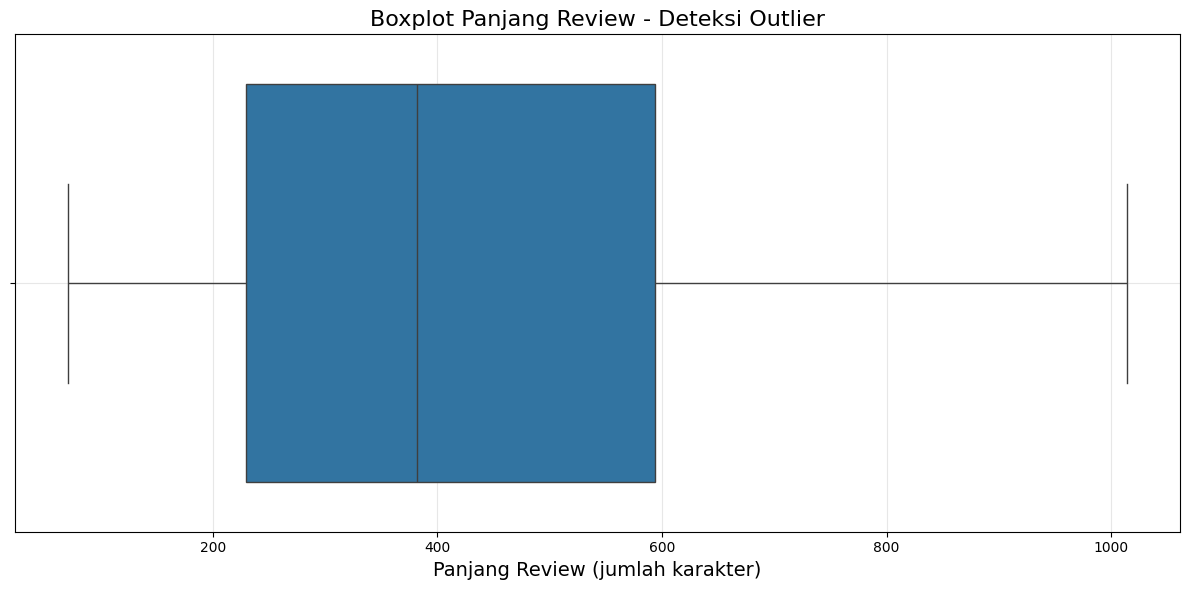

In [18]:
# Visualisasi
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_train['text_length'])
plt.title('Boxplot Panjang Review - Deteksi Outlier', fontsize=16)
plt.xlabel('Panjang Review (jumlah karakter)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
# Cek apakah ada outlier sebelum menampilkan sampel
if not outliers_text.empty:
    print(outliers_text.sample(5)[['text', 'text_length', 'label']])
else:
    print("Tidak ada outlier yang terdeteksi.")

Tidak ada outlier yang terdeteksi.


- **Jumlah Kata:** Terdeteksi **221 outlier** (0.01% dari total data) berdasarkan jumlah kata. Ini adalah ulasan dengan jumlah kata yang sangat tinggi dibandingkan mayoritas data. Boxplot menunjukkan beberapa titik data di luar whisker atas.

In [20]:
# Identifikasi outlier panjang review
q1_word = df_train['word_count'].quantile(0.25)
q3_word = df_train['word_count'].quantile(0.75)
iqr_word = q3_word - q1_word
lower_bound_word = q1_word - 1.5 * iqr_word
upper_bound_word = q3_word + 1.5 * iqr_word

outliers_word = df_train[(df_train['word_count'] < lower_bound_word) | (df_train['word_count'] > upper_bound_word)]
print(f"Jumlah outlier: {len(outliers_word)} ({len(outliers_word)/len(df_train):.2%} dari total)")

Jumlah outlier: 221 (0.01% dari total)


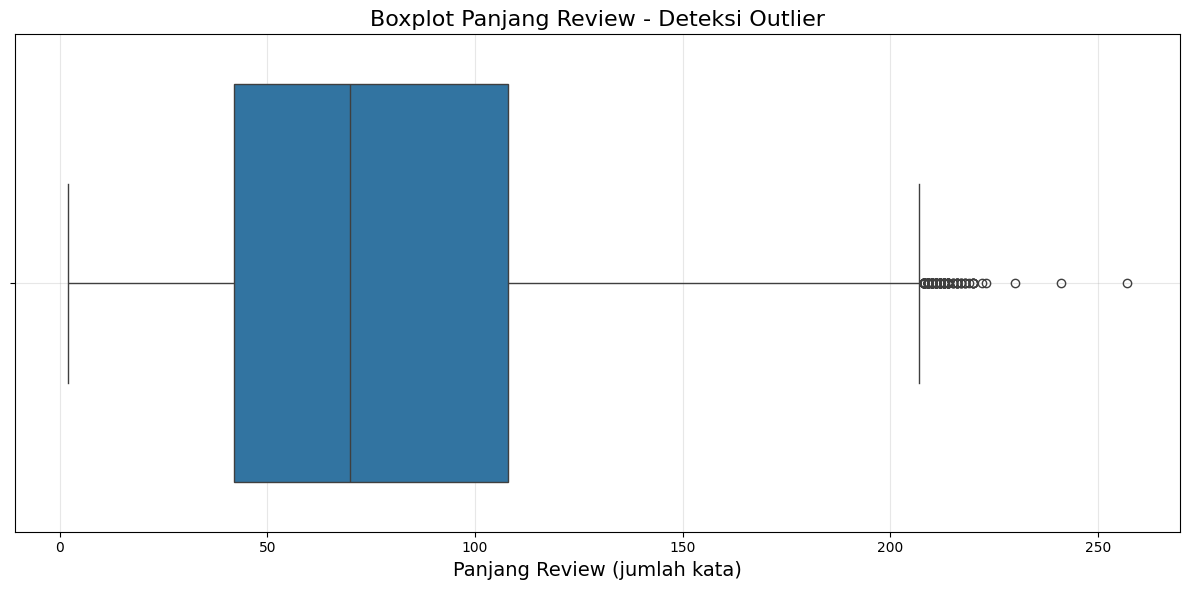

In [21]:
# Visualisasi
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_train['word_count'])
plt.title('Boxplot Panjang Review - Deteksi Outlier', fontsize=16)
plt.xlabel('Panjang Review (jumlah kata)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

- **Tindakan:** Outlier ini (bersama dengan data di luar kuartil Q1 dan Q3 untuk panjang teks dan jumlah kata) akan difilter sebelum melakukan sampling untuk preprocessing lebih lanjut.

In [22]:
# Cek apakah ada outlier sebelum menampilkan sampel
if not outliers_word.empty:
    print(outliers_word.sample(5)[['text', 'text_length', 'label']])
else:
    print("Tidak ada outlier yang terdeteksi.")


                                                      text  text_length  label
1469042  I just bought this back in December to heat my...         1008      1
2584472  I have had this item sitting on a shelf waitin...         1001      0
264555   I tried out the AIR POD last weekend on my fir...         1011      1
2208410  We purchased this TV the day after thanksgivin...         1010      0
2010461  I wish I had read the other review of this pro...         1007      0


**Box Plot: Deteksi Outlier Panjang Ulasan**

- Visualisasi: Dua box plot ditampilkan, satu untuk text_length dan satu untuk word_count pada dataset latih awal, digunakan untuk mengidentifikasi outlier statistik menggunakan metode Interquartile Range (IQR).

- Deskripsi Data: Box plot menunjukkan median (garis tengah kotak), kuartil pertama (Q1) dan ketiga (Q3) (batas kotak), serta "whisker" yang biasanya memanjang hingga 1.5 kali IQR dari Q1 dan Q3. Titik-titik di luar whisker dianggap sebagai outlier potensial.

- Insight:

    - Panjang Karakter: Box plot untuk text_length tidak menunjukkan adanya outlier di luar whisker. Artinya, meskipun ada ulasan yang sangat panjang (hingga ~1000 karakter), panjangnya tidak dianggap sebagai outlier statistik ekstrim relatif terhadap keseluruhan distribusi menggunakan ambang batas 1.5xIQR.

    - Jumlah Kata: Box plot untuk word_count menunjukkan adanya beberapa outlier di atas whisker atas. Perhitungan pada notebook mengidentifikasi 221 outlier (0.01% data). Ini adalah ulasan-ulasan dengan jumlah kata yang sangat tinggi (di atas ~207 kata berdasarkan perhitungan IQR) dibandingkan dengan sebagian besar ulasan lainnya.

    - Implikasi: Meskipun outlier panjang karakter tidak terdeteksi dengan metode ini, outlier jumlah kata terdeteksi. Namun, persentasenya sangat kecil (0.01%). Langkah selanjutnya melakukan filter berdasarkan rentang Q1-Q3 untuk panjang dan jumlah kata, yang secara efektif menghilangkan outlier ini dan juga memfokuskan analisis pada bagian data yang lebih padat distribusinya sebelum melakukan preprocessing teks yang intensif.

---

## 3. Data Preprocessing (Pada Data Sampel)

Karena ukuran dataset yang besar, dilakukan sampling sebelum preprocessing teks yang intensif komputasi.

### 3.1. Sampling Data

- **Kriteria Filter:** Data difilter terlebih dahulu untuk mempertahankan ulasan dengan panjang teks dan jumlah kata antara kuartil pertama (Q1) dan ketiga (Q3) yang dihitung pada EDA. Ini membantu menghilangkan sebagian ekstrem data.
- **Ukuran Sampel:**
  - **Data Latih (`df_train`):** 100.000 sampel (50.000 positif, 50.000 negatif) diambil secara acak dari data yang telah difilter.
  - **Data Validasi (`df_val`):** 20.000 sampel (10.000 positif, 10.000 negatif) diambil dari `df_test` yang telah difilter (menggunakan random state berbeda).
  - **Data Uji (`df_test`):** 30.000 sampel (15.000 positif, 15.000 negatif) diambil dari `df_test` yang telah difilter (menggunakan random state yang sama dengan train).
- **Hasil:** Dataset latih, validasi, dan uji yang lebih kecil dan seimbang kelasnya dibuat dan disimpan ke file CSV (`data/df_train.csv`, `data/df_val.csv`, `data/df_test.csv`).


In [ ]:
# Filter data berdasarkan panjang teks dan jumlah kata terlebih dahulu
filtered_df_train = df_train[
    (df_train['text_length'] >= q1_text) & 
    (df_train['text_length'] <= q3_text) & 
    (df_train['word_count'] >= q1_word) & 
    (df_train['word_count'] <= q3_word)
]

# Sampling untuk data train dari data yang sudah difilter
# Ambil 50.000 sampel dari masing-masing label (jika tersedia)
train_label_0 = filtered_df_train[filtered_df_train['label'] == 0].sample(
    n=min(50000, len(filtered_df_train[filtered_df_train['label'] == 0])), 
    random_state=42
)
train_label_1 = filtered_df_train[filtered_df_train['label'] == 1].sample(
    n=min(50000, len(filtered_df_train[filtered_df_train['label'] == 1])), 
    random_state=42
)

# Gabungkan kedua sampel untuk dataset train
df_train_sampled = pd.concat([train_label_0, train_label_1])

# Acak urutan data
df_train = df_train_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [46]:
# Cek jumlah data hasil sampling
print("Jumlah data train setelah sampling:", len(df_train))
print("Distribusi label train:")
print(df_train['label'].value_counts())

Jumlah data train setelah sampling: 100000
Distribusi label train:
label
1    50000
0    50000
Name: count, dtype: int64


In [47]:
df_train.to_csv('data/df_train.csv', index=False)

In [48]:
df_test['text_length'] = df_test['text'].apply(len)
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

In [49]:
# Filter data berdasarkan panjang teks dan jumlah kata terlebih dahulu
filtered_df_val = df_test[
    (df_test['text_length'] >= q1_text) & 
    (df_test['text_length'] <= q3_text) & 
    (df_test['word_count'] >= q1_word) & 
    (df_test['word_count'] <= q3_word)
]

# Sampling untuk data validation dari data yang sudah difilter
# Ambil 10.000 sampel dari masing-masing label (jika tersedia)
val_label_0 = filtered_df_val[filtered_df_val['label'] == 0].sample(
    n=min(10000, len(filtered_df_val[filtered_df_val['label'] == 0])), 
    random_state=369
)
val_label_1 = filtered_df_val[filtered_df_val['label'] == 1].sample(
    n=min(10000, len(filtered_df_val[filtered_df_val['label'] == 1])), 
    random_state=369
)

df_val_sampled = pd.concat([val_label_0, val_label_1])
df_val = df_val_sampled.sample(frac=1, random_state=369).reset_index(drop=True)

In [50]:
print("\nJumlah data validation setelah sampling:", len(df_val))
print("Distribusi label test:")
print(df_val['label'].value_counts())


Jumlah data validation setelah sampling: 20000
Distribusi label test:
label
1    10000
0    10000
Name: count, dtype: int64


In [51]:
df_val.to_csv('data/df_val.csv', index=False)

In [52]:
# Filter data berdasarkan panjang teks dan jumlah kata terlebih dahulu
filtered_df_test = df_test[
    (df_test['text_length'] >= q1_text) & 
    (df_test['text_length'] <= q3_text) & 
    (df_test['word_count'] >= q1_word) & 
    (df_test['word_count'] <= q3_word)
]

# Sampling untuk data test dari data yang sudah difilter
# Ambil 15.000 sampel dari masing-masing label (jika tersedia)
test_label_0 = filtered_df_test[filtered_df_test['label'] == 0].sample(
    n=min(15000, len(filtered_df_test[filtered_df_test['label'] == 0])), 
    random_state=42
)
test_label_1 = filtered_df_test[filtered_df_test['label'] == 1].sample(
    n=min(15000, len(filtered_df_test[filtered_df_test['label'] == 1])), 
    random_state=42
)

df_test_sampled = pd.concat([test_label_0, test_label_1])
df_test = df_test_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [53]:
print("\nJumlah data test setelah sampling:", len(df_test))
print("Distribusi label test:")
print(df_test['label'].value_counts())


Jumlah data test setelah sampling: 30000
Distribusi label test:
label
0    15000
1    15000
Name: count, dtype: int64


In [54]:
df_test.to_csv('data/df_test.csv', index=False)

### 3.2. Pipeline Pembersihan Teks

Pipeline pembersihan teks diterapkan pada kolom `text` dari `df_train` (yang sudah disampling):
1.  **`clean_text`:**
  - Konversi ke huruf kecil.
  - Hapus tag HTML.
  - Ekspansi kontraksi (misalnya, "don't" menjadi "do not").
  - Hapus URL, alamat email, dan mention pengguna (@user).
  - Ganti nomor produk/identifier panjang dengan token ' product '.
  - Ganti angka dengan token ' number '.
  - Hapus tanda baca.
  - Hapus spasi berlebih.
2.  **`remove_stopwords`:**
  - Hapus kata-kata umum (stopwords) bahasa Inggris, **kecuali** kata negasi (seperti 'no', 'not', 'never') karena penting untuk analisis sentimen.
3.  **`lemmatize_text`:**
  - Mengubah kata ke bentuk dasarnya (lemma) menggunakan `WordNetLemmatizer`. Stemming (opsional) juga didefinisikan tetapi lemmatisasi umumnya lebih disukai untuk sentimen.

- Hasil pembersihan disimpan dalam kolom baru: `cleaned_text`, `cleaned_no_stop`, `lemmatized_text`.

### Data Cleaning

In [55]:
def clean_text(text):
    """
    Comprehensive text cleaning function
    """
    if isinstance(text, float):  # Handle NaN values
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Ekspansi kontraksi (don't -> do not)
    text = contractions.fix(text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove user mentions (like @user)
    text = re.sub(r'@\w+', '', text)
    
    # Replace product model numbers and specific identifiers
    text = re.sub(r'\b[a-zA-Z0-9]{10,}\b', ' product ', text)
    
    # Replace numbers with 'number'
    text = re.sub(r'\d+', ' number ', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def remove_stopwords(text):
    """
    Remove stopwords while preserving negation words
    """
    stop_words = set(stopwords.words('english'))
    # Keep negation words as they're important for sentiment
    negation_words = {'no', 'not', 'nor', 'neither', "don't", "doesn't", "didn't", "wasn't", "weren't", "haven't", "hasn't", "hadn't", "can't", "couldn't", "shouldn't", "won't", "wouldn't", "isn't", "aren't"}
    stop_words = stop_words - negation_words
    
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

def lemmatize_text(text):
    """
    Lemmatize text to reduce words to their base form
    """
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

# Optional function for stemming (often lemmatization is preferred for sentiment analysis)
def stem_text(text):
    """
    Stem words in text
    """
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

### Advanced Preprocessing Pipeline

In [56]:
# Create a copy of the original dataframe to preserve original data
df_processed = df_train.copy()

In [57]:
# Apply cleaning functions
print("Applying text cleaning...")
df_processed['cleaned_text'] = df_processed['text'].apply(clean_text)
df_processed['cleaned_no_stop'] = df_processed['cleaned_text'].apply(remove_stopwords)
df_processed['lemmatized_text'] = df_processed['cleaned_no_stop'].apply(lemmatize_text)

Applying text cleaning...


In [58]:
# Check the results
print("\nPreprocessing results sample:")
for i in range(3):  # Show first 3 examples
    print(f"\nOriginal: {df_processed['text'].iloc[i][:100]}...")
    print(f"Cleaned: {df_processed['cleaned_text'].iloc[i][:100]}...")
    print(f"Cleaned (no stopwords): {df_processed['cleaned_no_stop'].iloc[i][:100]}...")
    print(f"Lemmatized: {df_processed['lemmatized_text'].iloc[i][:100]}...")


Preprocessing results sample:

Original: i use this book constantly. the herbs are easy to access, the material gives easy to follow informat...
Cleaned: i use this book product the herbs are easy to access the material gives easy to follow product on ho...
Cleaned (no stopwords): use book product herbs easy access material gives easy follow product product herbs life excellent r...
Lemmatized: use book product herb easy access material give easy follow product product herb life excellent read...

Original: This CD is a great example of heavy hardcore with a softer edge - but not too soft. This band is a f...
Cleaned: this cd is a great example of heavy hardcore with a softer edge but not too soft this band is a few ...
Cleaned (no stopwords): cd great example heavy hardcore softer edge not soft band years old many bands days trying combine s...
Lemmatized: cd great example heavy hardcore softer edge not soft band year old many band day trying combine scre...

Original: I haven't read

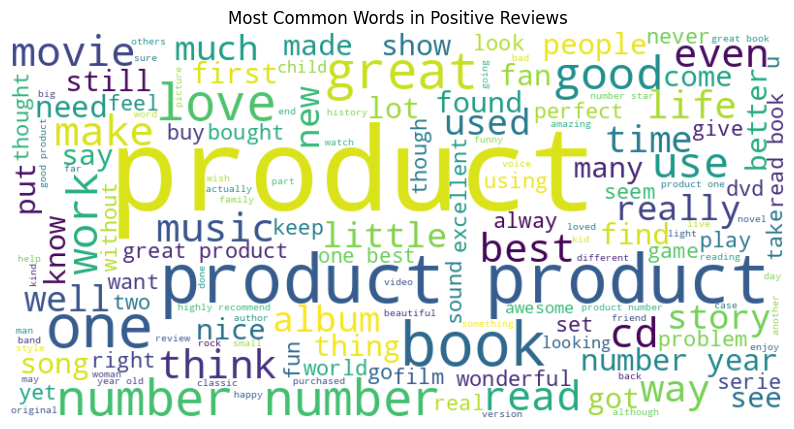

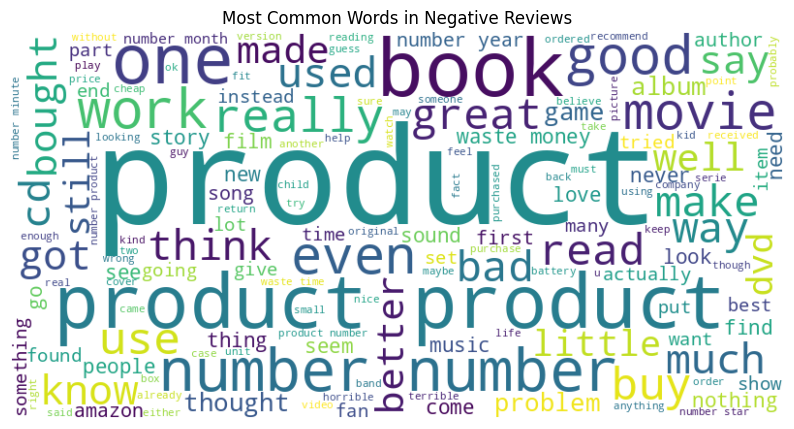

In [59]:
# Generate word clouds for each sentiment class
def generate_wordcloud(text_series, title):
    """Generate and display wordcloud"""
    all_text = ' '.join(text_series)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=150).generate(all_text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# binary sentiment (e.g., positive=1, negative=0)
positive_reviews = df_processed[df_processed['label'] == 1]['lemmatized_text']
negative_reviews = df_processed[df_processed['label'] == 0]['lemmatized_text']

generate_wordcloud(positive_reviews, 'Most Common Words in Positive Reviews')
generate_wordcloud(negative_reviews, 'Most Common Words in Negative Reviews')

**Word Cloud: Kata Paling Umum**

- Visualisasi: Dua word cloud ditampilkan, satu mewakili kata-kata paling sering muncul dalam ulasan positif dan satu lagi untuk ulasan negatif. Ukuran kata sebanding dengan frekuensinya. Word cloud ini dibuat setelah data disampling, dibersihkan, stopwords (kecuali negasi) dihapus, dan teks dilematisasi.

- Deskripsi Data: Kata-kata yang lebih besar muncul lebih sering dalam korpus teks sentimen tersebut.

- Insight:

    - Kata Umum & Artefak: Kata-kata seperti book, read, one, get, like, dan terutama number (hasil penggantian angka) sangat dominan di kedua cloud. Ini menunjukkan bahwa kata-kata yang sangat umum terkait domain (buku/produk Amazon) atau hasil dari preprocessing (seperti token "number") tidak dengan sendirinya membedakan sentimen.

    - Kata Kunci Sentimen Positif: Di cloud positif, kita melihat kata-kata seperti great, love, well, best, happy, perfect, recommend, amazing, wonderful, awesome. Ini adalah indikator kuat sentimen positif.

    - Kata Kunci Sentimen Negatif: Di cloud negatif, kata-kata seperti not, would (kemungkinan besar dalam konteks negatif seperti "would not recommend"), work (sering dalam "did not work"), problem, issue, waste, bad, poor, disappointed lebih menonjol. Kemunculan not yang signifikan mengonfirmasi keputusan untuk tidak menghapus kata negasi saat preprocessing stopwords, karena kata ini krusial untuk menangkap sentimen negatif.

    - Implikasi Fitur: Word cloud ini secara visual mengonfirmasi bahwa ada sinyal linguistik yang jelas untuk membedakan sentimen positif dan negatif dalam teks ulasan. Namun, dominasi kata-kata umum di kedua kelas juga menyoroti keterbatasan analisis frekuensi sederhana dan memperkuat kebutuhan akan teknik pembobotan kata yang lebih canggih seperti TF-IDF atau word embeddings untuk pemodelan, yang dapat menangkap nuansa dan pentingnya kata dalam konteks.

In [60]:
# Save processed data
df_processed.to_csv('data/df_processed.csv', index=False)

---

## 4. Feature Engineering (Pada Data Sampel yang Diproses)

Fitur-fitur baru dibuat dari teks untuk memperkaya representasi data sebelum pemodelan.

### 4.1. Fitur Berbasis Teks

Fitur-fitur ini diturunkan langsung dari karakteristik teks asli (sebelum pembersihan intensif, namun setelah penggabungan `title` dan `text`):
- `text_length`: Jumlah karakter.
- `word_count`: Jumlah kata.
- `avg_word_length`: Rata-rata panjang kata.
- `exclamation_count`: Jumlah tanda seru.
- `question_count`: Jumlah tanda tanya.
- `uppercase_word_count`: Jumlah kata yang seluruhnya huruf kapital (lebih dari 1 huruf).
- `uppercase_ratio`: Rasio kata huruf kapital terhadap total kata.

In [61]:
df_processed = pd.read_csv('./data/df_processed.csv')

In [62]:
# Text-based feature engineering
df_processed['text_length'] = df_processed['text'].apply(len)
df_processed['word_count'] = df_processed['text'].apply(lambda x: len(str(x).split()))
df_processed['avg_word_length'] = df_processed['text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]) if len(str(x).split()) > 0 else 0)
df_processed['exclamation_count'] = df_processed['text'].apply(lambda x: x.count('!'))
df_processed['question_count'] = df_processed['text'].apply(lambda x: x.count('?'))
df_processed['uppercase_word_count'] = df_processed['text'].apply(lambda x: sum(1 for word in x.split() if word.isupper() and len(word) > 1))
df_processed['uppercase_ratio'] = df_processed['uppercase_word_count'] / (df_processed['word_count'] + 1)  # +1 to avoid division by zero

### 4.2. Fitur Spesifik Sentimen

Fitur ini menghitung kemunculan kata-kata positif dan negatif umum dalam teks asli:
- `positive_word_count`: Jumlah kata positif umum.
- `negative_word_count`: Jumlah kata negatif umum.
- `sentiment_word_ratio`: Rasio (jumlah kata positif + 1) / (jumlah kata negatif + 1). Penambahan 1 untuk menghindari pembagian dengan nol.

In [63]:
# Sentiment-specific features
def count_positive_words(text):
    """Count appearance of common positive words"""
    positive_words = ['good', 'great', 'excellent', 'amazing', 'wonderful', 'best', 'love', 'perfect', 'recommend', 'happy', 'awesome']
    return sum(1 for word in text.lower().split() if word in positive_words)

def count_negative_words(text):
    """Count appearance of common negative words"""
    negative_words = ['bad', 'poor', 'terrible', 'horrible', 'worst', 'waste', 'disappointed', 'disappointing', 'difficult', 'hate', 'problem', 'issue', 'fail']
    return sum(1 for word in text.lower().split() if word in negative_words)

df_processed['positive_word_count'] = df_processed['text'].apply(count_positive_words)
df_processed['negative_word_count'] = df_processed['text'].apply(count_negative_words)
df_processed['sentiment_word_ratio'] = (df_processed['positive_word_count'] + 1) / (df_processed['negative_word_count'] + 1)

### 4.3. TF-IDF

- **Tujuan:** Memberikan bobot pada kata berdasarkan frekuensinya dalam dokumen dan keseluruhan korpus, mengurangi bobot kata umum dan meningkatkan bobot kata spesifik.
- **Implementasi:** `TfidfVectorizer` dari `sklearn` digunakan pada kolom `lemmatized_text`.
- **Parameter:**
  - `min_df=100`: Kata harus muncul minimal di 100 dokumen.
  - `max_df=0.75`: Kata tidak boleh muncul di lebih dari 75% dokumen.
  - `ngram_range=(1, 2)`: Mempertimbangkan unigram (kata tunggal) dan bigram (pasangan kata).
  - `max_features=10000`: Membatasi jumlah fitur (kata/ngram) menjadi 10.000 teratas.
- **Hasil:** Matriks TF-IDF (`tfidf_features`) dan vectorizer (`tfidf_vectorizer`) disimpan menggunakan `pickle` untuk digunakan nanti dalam pemodelan. Fitur teratas termasuk 'able', 'able find', 'able get', 'absolute', 'accept', 'access', 'accurate', dll.


In [64]:
# TF-IDF feature extraction (for n-grams)
print("Generating TF-IDF representations...")
tfidf_vectorizer = TfidfVectorizer(
    min_df=100,  # Minimum document frequency
    max_df=0.75,  # Maximum document frequency
    ngram_range=(1, 2),  # Use unigrams and bigrams
    max_features=10000  # Limit vocabulary size
)
tfidf_features = tfidf_vectorizer.fit_transform(df_processed['lemmatized_text'])

Generating TF-IDF representations...


In [65]:
# Show the most important TF-IDF features
feature_names = tfidf_vectorizer.get_feature_names_out()
print("\nTop TF-IDF features:")
for i, feature in enumerate(feature_names[:20]):
    print(f"{feature}")


Top TF-IDF features:
ability
able
able find
able get
able use
absolute
absurd
abuse
ac
academic
accent
accept
access
accident
according
account
accuracy
accurate
accurate product
achieve


---

## 5. Pembuatan DataFrame Akhir (`final_df`)

- DataFrame akhir (`final_df`) dibuat dengan memilih kolom-kolom yang relevan dari `df_processed`.
- Kolom yang dipilih:
  - `label`: Target variabel (0 atau 1).
  - `lemmatized_text`: Teks yang telah dibersihkan dan dilematisasi (kemungkinan akan digunakan untuk model berbasis teks seperti RNN/Transformer atau sebagai input tambahan).
  - Fitur-fitur hasil rekayasa dari langkah 4.1 dan 4.2.
- DataFrame ini kemudian disimpan sebagai `data/final_df.csv`.



In [66]:
# Create final dataset with selected features
# Choose the preprocessing level you prefer (cleaned_text, cleaned_no_stop, or lemmatized_text)
final_df = df_processed[['label', 'lemmatized_text', 'text_length', 'word_count', 'avg_word_length',
                        'exclamation_count', 'question_count', 'uppercase_ratio',
                        'positive_word_count', 'negative_word_count', 'sentiment_word_ratio']]

In [67]:
# Save processed data
final_df.to_csv('data/final_df.csv', index=False)

In [68]:
# Save TF-IDF features for later use (optional)
import pickle
with open('tfidf_features.pkl', 'wb') as f:
    pickle.dump({'features': tfidf_features, 'vectorizer': tfidf_vectorizer}, f)

print("Preprocessing complete! Data saved to 'final_df.csv'")

Preprocessing complete! Data saved to 'final_df.csv'


In [69]:
# Show summary statistics of the engineered features
print("\nEngineered features summary:")
print(final_df.describe())


Engineered features summary:
               label   text_length    word_count  avg_word_length  \
count  100000.000000  100000.00000  100000.00000    100000.000000   
mean        0.500000     394.28408      72.45959         4.473468   
std         0.500003     102.18181      18.98513         0.411110   
min         0.000000     230.00000      42.00000         2.486842   
25%         0.000000     306.00000      56.00000         4.190476   
50%         0.500000     385.00000      71.00000         4.434211   
75%         1.000000     478.00000      87.00000         4.712500   
max         1.000000     594.00000     127.00000         8.596154   

       exclamation_count  question_count  uppercase_ratio  \
count      100000.000000   100000.000000    100000.000000   
mean            0.920030        0.159090         0.020918   
std             2.648752        0.676051         0.087185   
min             0.000000        0.000000         0.000000   
25%             0.000000        0.000000   

## 6. Kesimpulan Proses

1.  Dataset ulasan Amazon yang besar dimuat dan dipersiapkan dengan penamaan kolom, pemetaan label, dan penggabungan teks.
2.  EDA mengungkapkan dataset awal sangat seimbang, dengan distribusi panjang teks dan jumlah kata yang miring ke kanan. Ulasan negatif cenderung sedikit lebih panjang/memiliki lebih banyak kata. Outlier minimal terdeteksi pada jumlah kata. WordCloud menunjukkan kata-kata umum dan beberapa kata kunci sentimen.
3.  Karena ukuran data, sampling dilakukan setelah memfilter berdasarkan kuartil panjang/jumlah kata, menghasilkan dataset latih (100k), validasi (20k), dan uji (30k) yang seimbang.
4.  Pipeline preprocessing teks (pembersihan, penghapusan stopwords dengan menjaga negasi, lemmatisasi) diterapkan pada data latih sampel.
5.  Fitur-fitur baru direkayasa berdasarkan karakteristik teks (panjang, tanda baca, kapitalisasi) dan konten sentimen (jumlah kata positif/negatif).
6.  Fitur TF-IDF (unigram & bigram) dihasilkan dari teks yang dilematisasi.
7.  DataFrame akhir (`final_df`) dibuat, menggabungkan label, teks yang diproses (lemmatized), dan fitur-fitur hasil rekayasa, siap untuk tahap pemodelan selanjutnya. File ini, bersama dengan data sampel dan fitur TF-IDF, disimpan untuk digunakan di langkah berikutnya.